# 사이킷런을 이용한 토픽 모델링

**데이터 준비**

In [ ]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space', 
              'comp.sys.ibm.pc.hardware', 'sci.crypt']

# 학습 데이터셋을 가져옴
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)

print('Train set size:', len(newsgroups_train.data))
print('Selected categories:', newsgroups_train.target_names)

Train set size: 3219
Selected categories: ['alt.atheism', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.crypt', 'sci.space', 'talk.religion.misc']


**토크나이징 및 카운트 벡터 생성**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(token_pattern="[\w']{3,}", stop_words='english', 
                     max_features=2000, min_df=5, max_df=0.5)
review_cv = cv.fit_transform(newsgroups_train.data) 

**LDA 토픽 모델링 실행**

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
np.set_printoptions(precision=3)

lda = LatentDirichletAllocation(n_components = 10, # 추출할 topic의 수
                                max_iter=5,         # 알고리즘 최대 반복 횟수
                                topic_word_prior=0.1, doc_topic_prior=1.0,  # 각각 β, α (둘다 기본값 1/n_components)
                                learning_method='online', 
                                n_jobs= -1,     # 사용 processor 수 (가능한 모든 프로세서 사용)
                                random_state=0)

review_topics = lda.fit_transform(review_cv)
print('shape of review_topics:', review_topics.shape)   # θ에 해당
print('Sample of review_topics:', review_topics[0])

gross_topic_weights = np.mean(review_topics, axis=0)
print('Sum of topic weights of documents:', gross_topic_weights)

print('shape of topic word distribution:', lda.components_.shape)   # ϕ에 해당

shape of review_topics: (3219, 10)
Sample of review_topics: [0.901 0.007 0.029 0.008 0.007 0.008 0.008 0.007 0.007 0.019]
Sum of topic weights of documents: [0.09  0.083 0.081 0.114 0.117 0.136 0.085 0.072 0.072 0.151]
shape of topic word distribution: (10, 2000)


In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        # 위 slicing에서 맨 뒤 -1은 역순을 의미, 역순으로 했을 때 처음부터 n_top_words까지
    print()

print_top_words(lda,cv.get_feature_names_out(), 10)

Topic #0: com, morality, keith, article, sgi, think, sandvik, caltech, objective, moral
Topic #1: image, graphics, file, files, ftp, available, software, use, data, pub
Topic #2: space, access, launch, earth, orbit, digex, lunar, shuttle, satellite, com
Topic #3: article, com, just, like, don't, university, i'm, nntp, host, posting
Topic #4: key, clipper, chip, encryption, com, government, law, keys, use, escrow
Topic #5: scsi, com, posting, nntp, host, thanks, bit, university, ibm, know
Topic #6: nasa, gov, university, host, posting, nntp, ___, distribution, center, washington
Topic #7: drive, com, disk, hard, controller, drives, dos, tape, problem, floppy
Topic #8: key, public, mail, faq, message, pgp, group, des, posting, university
Topic #9: god, people, don't, jesus, just, believe, say, does, think, know



**최적의 토픽 수 선택하기**

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_perplexity(cv, start=10, end=30, max_iter=5, topic_word_prior= 0.1,    # max_iter 너무 낮추면 perplexity가 높아지고 토픽 수에 비례함
                    doc_topic_prior=1.0):
    iter_num = []
    per_value = []

    for i in range(start, end + 1):
        lda = LatentDirichletAllocation(n_components = i, max_iter=max_iter, 
                                        topic_word_prior= topic_word_prior, 
                                        doc_topic_prior=doc_topic_prior,
                                        learning_method='batch', n_jobs= -1,
                                        random_state=7)    
        lda.fit(cv)
        iter_num.append(i)
        pv = lda.perplexity(cv)
        per_value.append(pv)
        print(f'n_components: {i}, perplexity: {pv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.show()
    return start + per_value.index(min(per_value))

n_components: 6, perplexity: 1063.362
n_components: 7, perplexity: 1045.636
n_components: 8, perplexity: 1015.561
n_components: 9, perplexity: 1016.494
n_components: 10, perplexity: 1028.560
n_components: 11, perplexity: 1036.692
n_components: 12, perplexity: 1032.437
n_components: 13, perplexity: 1038.319
n_components: 14, perplexity: 1040.664
n_components: 15, perplexity: 1046.556


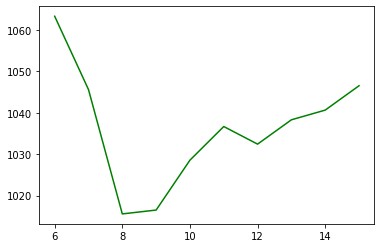

n_components with minimum perplexity: 8


In [ ]:
print("n_components with minimum perplexity:",
      show_perplexity(review_cv, start=6, end=15))

In [ ]:
lda = LatentDirichletAllocation(n_components = 8, # 추출할 topic의 수를 지정
                                max_iter=20, 
                                topic_word_prior= 0.1, 
                                doc_topic_prior=1.0,
                                learning_method='batch',    # online 보다 성능이 좋고 느리다.
                                n_jobs= -1, 
                                random_state=7)

review_topics = lda.fit_transform(review_cv)

print_top_words(lda, cv.get_feature_names_out(), 10)

Topic #0: image, graphics, mail, available, file, ftp, data, files, software, information
Topic #1: nasa, gov, posting, space, university, host, nntp, ___, center, distribution
Topic #2: com, keith, article, morality, think, posting, nntp, caltech, don't, host
Topic #3: com, article, jesus, know, just, posting, host, nntp, don't, i'm
Topic #4: people, god, does, don't, think, say, believe, just, way, like
Topic #5: drive, scsi, card, com, disk, thanks, ide, controller, bus, hard
Topic #6: space, access, article, launch, just, year, like, digex, moon, com
Topic #7: key, encryption, clipper, chip, com, government, keys, use, security, public



# Gensim을 이용한 토픽 모델링

**Tokenizing**

In [ ]:
!pip install --upgrade gensim

In [ ]:
import nltk
nltk.download('stopwords') 

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

cachedStopWords = stopwords.words("english")

RegTok = RegexpTokenizer("[\w']{3,}")       # 정규포현식으로 토크나이저를 정의
english_stops = set(stopwords.words('english'))     # 영어 불용어를 가져옴

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def tokenizer(text):
    tokens = RegTok.tokenize(text.lower()) 
    # stopwords 제외
    words = [word for word in tokens if (word not in english_stops) and len(word) > 2]
    return words

In [ ]:
texts = [tokenizer(news) for news in newsgroups_train.data]

**Gensim에서 사용하는 id 매칭하는 사전 생성**

In [ ]:
from gensim.corpora.dictionary import Dictionary

# 토큰화 결과로부터 dictionay 생성
dictionary = Dictionary(texts)

print('Number of initial unique words in documents:', len(dictionary))

# 문서 빈도수가 너무 적거나 높은 단어를 필터링하고 특성을 단어의 빈도 순으로 선택
dictionary.filter_extremes(keep_n=2000, no_below=5, no_above=0.5)

print('Number of unique words after removing rare and common words:', len(dictionary))

Number of initial unique words in documents: 46466
Number of unique words after removing rare and common words: 2000


In [ ]:
# 카운트 벡터로 변환
corpus = [dictionary.doc2bow(text) for text in texts]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 2000
Number of documents: 3219


**LDA 토픽 모델링 실행**

In [ ]:
from gensim.models import LdaModel

num_topics = 10     # 추출할 topic의 수를 지정
passes = 5          # 알고리즘 최대 반복 횟수

model = LdaModel(corpus=corpus, id2word=dictionary,\
                passes=passes, num_topics=num_topics, \
                random_state=7)

In [ ]:
# 각 토픽의 상위 비중 단어 10개 출력
model.print_topics(num_words=10)

[(0,
  '0.023*"com" + 0.018*"keith" + 0.016*"caltech" + 0.013*"sgi" + 0.013*"nntp" + 0.013*"posting" + 0.013*"host" + 0.012*"would" + 0.012*"system" + 0.011*"livesey"'),
 (1,
  '0.020*"morality" + 0.018*"objective" + 0.015*"one" + 0.015*"say" + 0.014*"uiuc" + 0.012*"frank" + 0.012*"values" + 0.010*"faq" + 0.010*"article" + 0.008*"cso"'),
 (2,
  '0.026*"com" + 0.025*"access" + 0.025*"posting" + 0.023*"host" + 0.023*"nntp" + 0.017*"digex" + 0.015*"article" + 0.013*"cwru" + 0.013*"___" + 0.013*"net"'),
 (3,
  '0.021*"university" + 0.017*"posting" + 0.015*"host" + 0.015*"nntp" + 0.013*"article" + 0.010*"com" + 0.009*"know" + 0.009*"i\'m" + 0.009*"would" + 0.009*"thanks"'),
 (4,
  '0.032*"com" + 0.015*"would" + 0.011*"article" + 0.010*"one" + 0.010*"get" + 0.009*"people" + 0.009*"ibm" + 0.008*"government" + 0.007*"good" + 0.007*"i\'m"'),
 (5,
  '0.025*"key" + 0.017*"encryption" + 0.014*"clipper" + 0.014*"chip" + 0.009*"keys" + 0.009*"use" + 0.008*"security" + 0.008*"government" + 0.008*"pub

In [ ]:
print("topic distribution of the first document: ", model.get_document_topics(corpus)[0])

topic distribution of the first document:  [(0, 0.72576934), (8, 0.2699505)]


**`pyLDAvis`로 토픽 모델링 결과 시각화**

In [ ]:
!pip install pyLDAvis

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(model, corpus, dictionary)
lda_viz

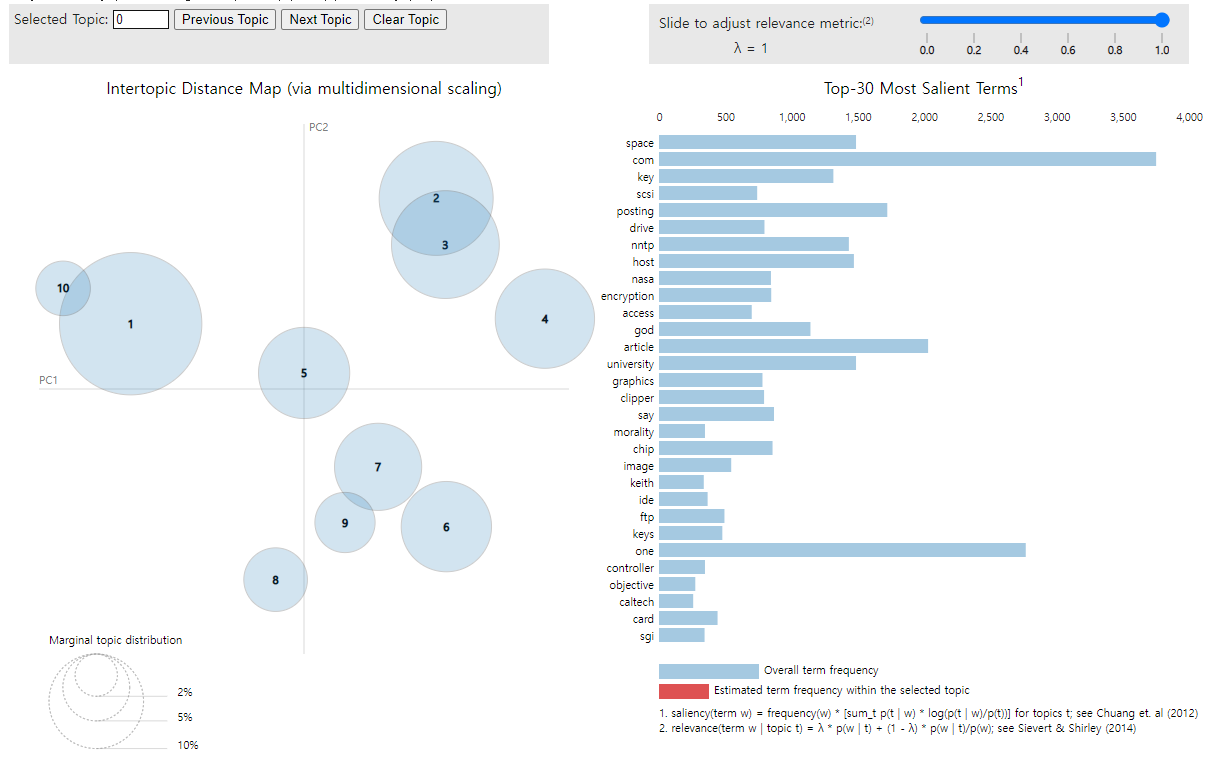

**혼란도와 토픽 응집도를 이용한 최적값 선택**

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from gensim.models import CoherenceModel

In [ ]:
def show_coherence(corpus, dictionary, start=6, end=15):
    iter_num = []
    per_value = []
    coh_value = []

    for i in range(start, end + 1):
        model = LdaModel(corpus=corpus, id2word=dictionary,
                 chunksize=1000, num_topics=i,
                 random_state=7)
        
        iter_num.append(i)
        pv = model.log_perplexity(corpus)   # 혼란도 계산
        per_value.append(pv)
        
        # 토픽 응집도 계산
        cm = CoherenceModel(model=model, corpus=corpus, 
                            coherence='u_mass')
        cv = cm.get_coherence()
        coh_value.append(cv)

        print(f'num_topics: {i}, perplexity: {pv:0.3f}, coherence: {cv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.xlabel("num_topics")
    plt.ylabel("perplexity")
    plt.show()

    plt.plot(iter_num, coh_value, 'r--')
    plt.xlabel("num_topics")
    plt.ylabel("coherence")
    plt.show()


num_topics: 6, perplexity: -7.035, coherence: -1.701
num_topics: 7, perplexity: -7.023, coherence: -1.735
num_topics: 8, perplexity: -7.023, coherence: -1.547
num_topics: 9, perplexity: -7.007, coherence: -1.891
num_topics: 10, perplexity: -6.996, coherence: -1.888
num_topics: 11, perplexity: -7.027, coherence: -2.164
num_topics: 12, perplexity: -7.019, coherence: -2.018
num_topics: 13, perplexity: -7.025, coherence: -2.255
num_topics: 14, perplexity: -7.020, coherence: -2.082
num_topics: 15, perplexity: -7.019, coherence: -2.521


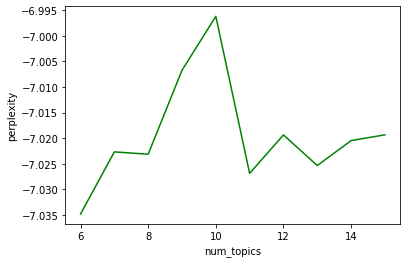

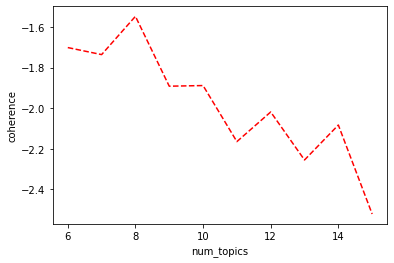

In [ ]:
show_coherence(corpus, dictionary, start=6, end=15)